## Play with complete dataset from uci.edu

The objective of this is to better my learning with the complete datasest that is got from uci.edu archieves

In [13]:
import io
import numpy as np
import pandas as pd
import codecs # For file reading
from IPython.display import FileLink # For displaying file link in cell-output

%matplotlib inline
import matplotlib.pyplot as plt

## Read raw source and save it as csv file

In [ ]:
# How do the lines look like in the target file?
!head -n 10 ./data/uci_edu/SMSSpamCollection.txt

In [ ]:
# Read input source
with codecs.open('./data/uci_edu/SMSSpamCollection.txt') as f:
    labels, messages = zip(*[line.split('\t', maxsplit=2) for line in f.readlines()])

In [ ]:
# Persist input source as CSV file
df = pd.DataFrame(data={ 'Message' : messages, 'Label' : labels})
df.to_csv('data/uci_edu/{}'.format('SMSSpamCollection.csv'), index=False)
FileLink('data/uci_edu/{}'.format('SMSSpamCollection.csv'))
df.head()

## Shuffle-N-Split input source for Train-N-Test

In [ ]:
df.isnull().sum() # Basic sanity check for null values

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, random_state=42, train_size=.7)
splits = sss.split(df, df['Label'])
train_indices, test_indices = [*splits][0]

In [ ]:
print('Total Count = ', df.shape[0])
print()

train_mask = df.index.isin(train_indices)
train = df[train_mask]
print('Train Count = ', train.shape[0])
print('Train value counts :\n', train['Label'].value_counts())
print()

test = df[~train_mask]
print('Test Count = ', test.shape[0])
print('Test value counts :\n', test['Label'].value_counts())

In [ ]:
train.to_csv('data/uci_edu/train.csv', index_label=['Id'])
test.to_csv('data/uci_edu/test.csv', index_label=['Id'])

## Feature Extraction and Data Modeling

In [18]:
train = pd.read_csv('data/uci_edu/train.csv', index_col='Id')
test = pd.read_csv('data/uci_edu/test.csv', index_col='Id')

train['Label'] = train['Label'].apply(lambda y : 1 if y=='spam' else 0)
test['Label'] = test['Label'].apply(lambda y : 1 if y=='spam' else 0)

print(train.head())
print()
print(test.head())

                                              Message  Label
Id                                                          
0   Go until jurong point, crazy.. Available only ...      0
1                   Ok lar... Joking wif u oni...\r\n      0
3   U dun say so early hor... U c already then say...      0
8   WINNER!! As a valued network customer you have...      1
9   Had your mobile 11 months or more? U R entitle...      1

                                              Message  Label
Id                                                          
2   Free entry in 2 a wkly comp to win FA Cup fina...      1
4   Nah I don't think he goes to usf, he lives aro...      0
5   FreeMsg Hey there darling it's been 3 week's n...      1
6   Even my brother is not like to speak with me. ...      0
7   As per your request 'Melle Melle (Oru Minnamin...      0


In [22]:
# Vectorizer or Feature Extractors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

In [25]:
def vectorize_fit_score(vectorizer, classifier, train_df, test_df):
    desc = '{0} and {1}'.format(vectorizer.__class__.__name__, classifier.__class__.__name__)
#     print('Processing with {}'.format(desc))
    
    # 1. vectorize and fit
    vectorized_text = vectorizer.fit_transform(train_df['Message'])
    classifier.fit(vectorized_text, train_df['Label'])
    # 2. vectorize and score
    vectorized_text = vectorizer.transform(test_df['Message']) # Not `fit_transform` but just `transform`
    score = classifier.score(vectorized_text, test_df['Label'])
    
    return [desc, score]

In [ ]:
results = []
results.append(vectorize_fit_score(CountVectorizer(), BernoulliNB(), train, test))
results.append(vectorize_fit_score(TfidfVectorizer(), BernoulliNB(), train, test))
results.append(vectorize_fit_score(HashingVectorizer(), BernoulliNB(), train, test))
results.append(vectorize_fit_score(CountVectorizer(), MultinomialNB(), train, test))
results.append(vectorize_fit_score(TfidfVectorizer(), MultinomialNB(), train, test))
results.append(vectorize_fit_score(HashingVectorizer(non_negative=True), MultinomialNB(), train, test))
results

In [26]:
import itertools

vectorizers = [ 
    CountVectorizer(), 
    TfidfVectorizer(), 
    HashingVectorizer(alternate_sign=False)
]

classifiers = [
    DummyClassifier(), # Just for fun :)
    BernoulliNB(), 
    MultinomialNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),    
    RandomForestClassifier(n_estimators=100, n_jobs=-1), 
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    PassiveAggressiveClassifier(max_iter=100),
    SGDClassifier(max_iter=100),
    LogisticRegression(),
    OneVsRestClassifier(SVC(kernel='linear')),
    OneVsRestClassifier(LogisticRegression()),    
    CalibratedClassifierCV(),    
]

# cvs = [(c,v) for c in classifiers for v in vectorizers]
# Doing it lazily with generators
cvs = itertools.product(classifiers, vectorizers)
results = []
for cv in cvs:
    res = vectorize_fit_score(cv[1], cv[0], train, test)
    results.append(res)
results    

[['CountVectorizer and DummyClassifier', 0.7776449491930664],
 ['TfidfVectorizer and DummyClassifier', 0.7638971906754334],
 ['HashingVectorizer and DummyClassifier', 0.7704722056186492],
 ['CountVectorizer and BernoulliNB', 0.9778840406455469],
 ['TfidfVectorizer and BernoulliNB', 0.9778840406455469],
 ['HashingVectorizer and BernoulliNB', 0.8661087866108786],
 ['CountVectorizer and MultinomialNB', 0.9844590555887627],
 ['TfidfVectorizer and MultinomialNB', 0.9605499103407054],
 ['HashingVectorizer and MultinomialNB', 0.8852361028093245],
 ['CountVectorizer and KNeighborsClassifier', 0.9252839210998207],
 ['TfidfVectorizer and KNeighborsClassifier', 0.917513448894202],
 ['HashingVectorizer and KNeighborsClassifier', 0.9234907352062164],
 ['CountVectorizer and DecisionTreeClassifier', 0.972504482964734],
 ['TfidfVectorizer and DecisionTreeClassifier', 0.9671249252839211],
 ['HashingVectorizer and DecisionTreeClassifier', 0.972504482964734],
 ['CountVectorizer and ExtraTreeClassifier', 

In [17]:
results_df = pd.DataFrame(data=results, columns=['Description', 'Score'])
results_df.to_csv('data/uci_edu/outputs/results.csv', header=True, index_label='Id')
FileLink('data/uci_edu/outputs/results.csv')
results_df[results_df.Score > 0.985].sort_values(['Score'],ascending=[False])

,Description,Score
49,TfidfVectorizer and OneVsRestClassifier,0.987448
55,TfidfVectorizer and CalibratedClassifierCV,0.987448
41,HashingVectorizer and PassiveAggressiveClassifier,0.986850
43,TfidfVectorizer and SGDClassifier,0.986850
56,HashingVectorizer and CalibratedClassifierCV,0.986850
34,TfidfVectorizer and RidgeClassifier,0.986252
37,TfidfVectorizer and RidgeClassifierCV,0.986252
40,TfidfVectorizer and PassiveAggressiveClassifier,0.985655
44,HashingVectorizer and SGDClassifier,0.985655
54,CountVectorizer and CalibratedClassifierCV,0.985655


Classification Report:
              precision    recall  f1-score   support

        ham       0.98      1.00      0.99      1449
       spam       0.99      0.87      0.93       224

avg / total       0.98      0.98      0.98      1673

Confusion Matrix:
 [[1447    2]
 [  29  195]]


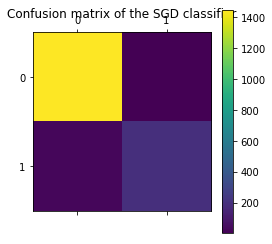

In [23]:
# OBJECTIVE : Analysing the top performer

clf = SGDClassifier(max_iter=100, loss='log')
vect = TfidfVectorizer()

# 1. vectorize and fit
vectorized_text = vect.fit_transform(train['Message'])
clf.fit(vectorized_text, train['Label'])

# 2. vectorize and score
vectorized_text = vect.transform(test['Message'])
preds = clf.predict(vectorized_text)
proba = clf.predict_proba(vectorized_text)
spam_proba = proba[:,1]

clf_score = clf.score(vectorized_text, test['Label'])
acc_score = accuracy_score(test['Label'],preds)
auc_score = roc_auc_score(test['Label'],spam_proba)

creport = classification_report(test['Label'], preds, target_names=['ham','spam'])
print('Classification Report:\n',creport)

cmat = confusion_matrix(test['Label'],preds)
print('Confusion Matrix:\n', cmat)

# Show confusion matrix
plt.matshow(cmat)
plt.title('Confusion matrix of the %s classifier' % 'SGD')
plt.colorbar()

## Playground

In [ ]:
import itertools
a = [1,2,3]
b = ['a','b','c']
for p in itertools.product(a,b):
    print(p[])